# ERA5 Dataset Exploration

## Dataset Overview

**ERA5** is the fifth generation ECMWF atmospheric reanalysis providing:
- Hourly global climate estimates from 1950 to present
- Spatial resolution: ~0.1° × 0.1° (ERA5-Land) or ~31 km
- Variables: Temperature, precipitation, wind, pressure, and 100+ additional parameters

In [12]:
import os
import glob

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import xarray as xr

## 1. Methodology: Setup and Data Loading

### Coordinate Reference System

The analysis uses **EPSG:4326** (WGS 84):
- Standard geographic coordinate system for global climate data
- Latitude: -90° (South Pole) to +90° (North Pole)
- Longitude: -180° (West) to +180° (East)
- Units: Decimal degrees

In [13]:
era5_crs = "EPSG:4326"

### Data Configuration

Variable mappings for ERA5 nomenclature and statistical aggregations:

In [14]:
# Variable of interest - try changing this to explore different variables!
# Options: "2m_temperature", "total_precipitation", "10m_u_component_of_wind", "10m_v_component_of_wind"
voi = "2m_temperature"

# The directory where data files are stored
data_dir = "../data/"

In [15]:
era5_data_folder = os.path.join(data_dir, "derived-era5-land-daily-statistics")

# Mapping from variable names to their statistical aggregations
variable2statistic = {
    "2m_temperature": "daily_maximum",           # Maximum temperature each day
    "total_precipitation": "daily_mean",         # Mean precipitation each day
    "10m_u_component_of_wind": "daily_mean",     # Mean eastward wind component
    "10m_v_component_of_wind": "daily_mean",     # Mean northward wind component
}

# Mapping to the actual variable names in the NetCDF files
variable2datavar = {
    "2m_temperature": "t2m",          # Temperature at 2 meters above surface
    "total_precipitation": "tp",      # Total precipitation
    "10m_u_component_of_wind": "u10", # U (eastward) wind component at 10m
    "10m_v_component_of_wind": "v10", # V (northward) wind component at 10m
}

statistic = variable2statistic[voi]
datavar = variable2datavar[voi]

print(f"✓ Analyzing variable: {voi}")
print(f"  Statistical aggregation: {statistic}")
print(f"  NetCDF variable name: {datavar}")

✓ Analyzing variable: 2m_temperature
  Statistical aggregation: daily_maximum
  NetCDF variable name: t2m


### Data Ingestion Pipeline

Multiple NetCDF files (one per year) are combined using `xarray.open_mfdataset()` with coordinate-based merging.

In [16]:
era5_glob_pattern = os.path.join(era5_data_folder, f"*_{voi}_{statistic}.nc")
era5_filepaths = glob.glob(era5_glob_pattern)
era5_filepaths.sort()

print(f"Found {len(era5_filepaths)} files:")
for fp in era5_filepaths:
    print(" -", fp)

Found 6 files:
 - ../data/derived-era5-land-daily-statistics/2020_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2021_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2022_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2023_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2024_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2025_2m_temperature_daily_maximum.nc


In [17]:
era5_ds = xr.open_mfdataset(era5_filepaths, combine="by_coords")
era5_ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2098, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(23, 22, 42), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...

## 2. Data Structure Analysis

### Dimensional Properties

The dataset follows standard gridded climate data conventions with three dimensions:
- **time (valid_time)**: Temporal axis with daily observations
- **latitude**: North-South spatial dimension (descending order)
- **longitude**: East-West spatial dimension (ascending order)

In [18]:
era5_var = era5_ds[datavar]
era5_var

<xarray.DataArray 't2m' (valid_time: 2098, latitude: 350, longitude: 660)> Size: 2GB
dask.array<concatenate, shape=(2098, 350, 660), dtype=float32, chunksize=(23, 22, 42), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

### Dataset Characteristics

In [19]:
print(f"Data Shape: {era5_var.shape}")
print(f"   - Time steps: {len(era5_var.valid_time)}")
print(f"   - Latitude points: {len(era5_var.latitude)}")
print(f"   - Longitude points: {len(era5_var.longitude)}")
print("\nTime Coverage:")
print(f"   - Start: {era5_var.valid_time.min().values}")
print(f"   - End: {era5_var.valid_time.max().values}")
print("\nGeographic Coverage:")
print(f"   - Latitude: {era5_var.latitude.min().values:.2f}° to {era5_var.latitude.max().values:.2f}°")
print(f"   - Longitude: {era5_var.longitude.min().values:.2f}° to {era5_var.longitude.max().values:.2f}°")

Data Shape: (2098, 350, 660)
   - Time steps: 2098
   - Latitude points: 350
   - Longitude points: 660

Time Coverage:
   - Start: 2020-01-01T00:00:00.000000000
   - End: 2025-09-28T00:00:00.000000000

Geographic Coverage:
   - Latitude: 35.00° to 69.90°
   - Longitude: -25.00° to 40.90°


## 3. Visualization: Continental Scale

### Full Domain Temperature Distribution

Visualization of the complete geographic domain using indexed selection (`isel`) for the first time step:

In [20]:
era5_var_day = era5_var.isel(valid_time=0)

<Figure size 640x480 with 0 Axes>

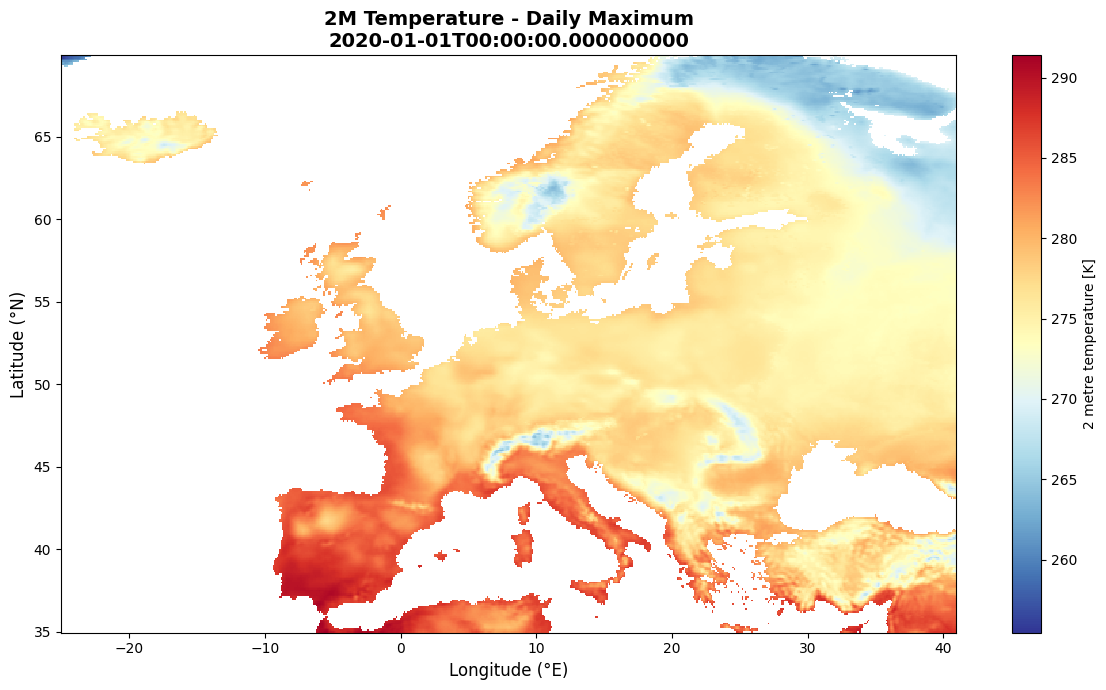

In [21]:
plt.figure()
era5_var_day.plot(figsize=(12, 7), cmap="RdYlBu_r")
plt.title(
    f"{voi.replace('_', ' ').title()} - {statistic.replace('_', ' ').title()}\n{era5_var_day.valid_time.values}",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.tight_layout()
plt.show()

## 4. Spatial Resolution Analysis

### Grid Cell Physical Dimensions

ERA5-Land employs a 0.1° × 0.1° grid. The physical distance represented by each grid cell varies with latitude due to Earth's spherical geometry.

In [22]:
# Constants: distance per degree at the equator
lat_deg_len_eq = 110.574  # km per degree latitude
lon_deg_len_eq = 111.320  # km per degree longitude at equator

# Calculate grid spacing
latitude_step = np.abs(era5_var.latitude[1] - era5_var.latitude[0]).item()
longitude_step = np.abs(era5_var.longitude[1] - era5_var.longitude[0]).item()

print("Grid Resolution:")
print(f"   Latitude spacing: {latitude_step:.4f}°")
print(f"   Longitude spacing: {longitude_step:.4f}°")

# How resolution changes with latitude
print("\nPhysical distance per grid cell at different latitudes:")
print("=" * 70)

km_per_deg = pd.DataFrame(
    {
        "Latitude (°)": [0, 15, 30, 45, 60, 75, 90],
        "Lat (km/deg)": [110.574, 110.649, 110.852, 111.133, 111.412, 111.618, 111.694],
        "Lon (km/deg)": [111.320, 107.551, 96.486, 78.847, 55.800, 28.902, 0.000],
    }
)

for index, row in km_per_deg.iterrows():
    lat_km = row["Lat (km/deg)"] * latitude_step
    lon_km = row["Lon (km/deg)"] * longitude_step
    cell_area = lat_km * lon_km
    print(
        f"At {row['Latitude (°)']:>3.0f}° latitude: "
        f"{lat_km:>5.2f} km (N-S) × {lon_km:>5.2f} km (E-W) = {cell_area:>7.1f} km²"
    )

🔍 Grid Resolution:
   Latitude spacing: 0.1000°
   Longitude spacing: 0.1000°

📏 Physical distance per grid cell at different latitudes:
At   0° latitude: 11.06 km (N-S) × 11.13 km (E-W) =   123.1 km²
At  15° latitude: 11.06 km (N-S) × 10.76 km (E-W) =   119.0 km²
At  30° latitude: 11.09 km (N-S) ×  9.65 km (E-W) =   107.0 km²
At  45° latitude: 11.11 km (N-S) ×  7.88 km (E-W) =    87.6 km²
At  60° latitude: 11.14 km (N-S) ×  5.58 km (E-W) =    62.2 km²
At  75° latitude: 11.16 km (N-S) ×  2.89 km (E-W) =    32.3 km²
At  90° latitude: 11.17 km (N-S) ×  0.00 km (E-W) =     0.0 km²


## 5. Regional Analysis: Italy

### Spatial Subsetting Methodology

Extracted data for Italy using geographic bounding box selection.

ERA5 latitude coordinates are stored in descending order (North→South), requiring reversed slice bounds.

**Italy Bounding Box:**
- Latitude: 36.619°N to 47.092°N
- Longitude: 6.627°E to 18.784°E

In [32]:
italy_bbox = {"min_lon": 6.627, "max_lon": 18.784, "min_lat": 36.619, "max_lat": 47.092}

era5_var_italy = era5_var.sel(
    longitude=slice(italy_bbox["min_lon"], italy_bbox["max_lon"]),
    latitude=slice(italy_bbox["max_lat"], italy_bbox["min_lat"]),
)

era5_var_italy

<xarray.DataArray 't2m' (valid_time: 2098, latitude: 104, longitude: 121)> Size: 106MB
dask.array<getitem, shape=(2098, 104, 121), dtype=float32, chunksize=(23, 22, 42), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 832B 47.0 46.9 46.8 46.7 ... 36.9 36.8 36.7
  * longitude   (longitude) float64 968B 6.7 6.8 6.9 7.0 ... 18.4 18.5 18.6 18.7
    number      int64 8B 0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

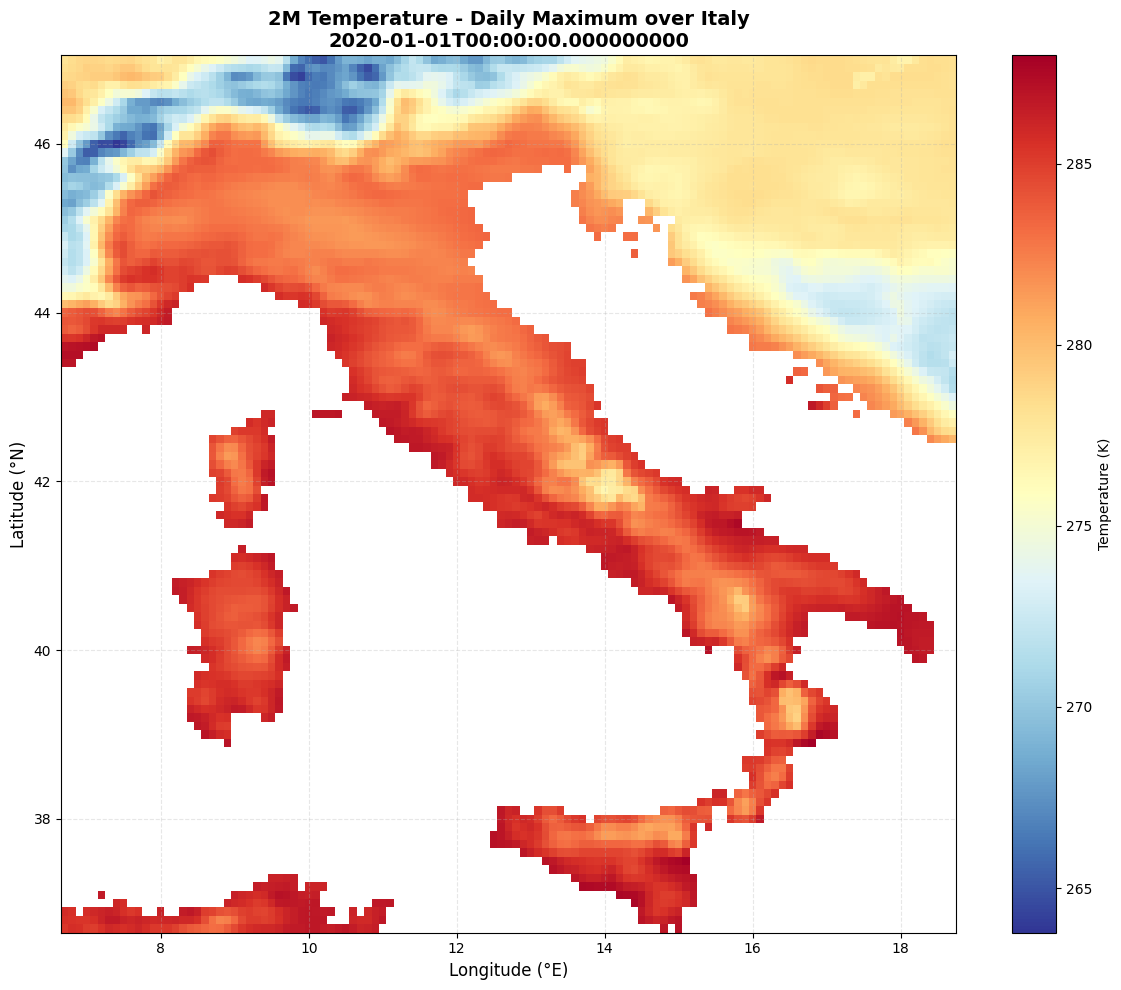

In [24]:
# Visualize temperature over Italy for the first day
fig, ax = plt.subplots(figsize=(12, 10))
era5_var_italy.isel(valid_time=0).plot(ax=ax, cmap='RdYlBu_r', cbar_kwargs={'label': 'Temperature (K)'})
plt.title(f"{voi.replace('_', ' ').title()} - {statistic.replace('_', ' ').title()} over Italy\n{str(era5_var_italy.isel(valid_time=0).valid_time.values)}",
          fontsize=14, fontweight='bold')
plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 6. Temporal Analysis

### Point-Based Time Series Extraction

Time series extracted for major Italian cities using nearest-neighbor coordinate matching:

In [33]:
cities = {
    "Rome": {"lat": 41.9028, "lon": 12.4964},
    "Milan": {"lat": 45.4642, "lon": 9.1900},
    "Naples": {"lat": 40.8518, "lon": 14.2681},
    "Palermo": {"lat": 38.1157, "lon": 13.3615},
}

# Extract time series for Rome using nearest neighbor selection
rome_ts = era5_var_italy.sel(
    latitude=cities["Rome"]["lat"], longitude=cities["Rome"]["lon"], method="nearest"
)

print(f"Data points: {len(rome_ts)}")

Data points: 2098


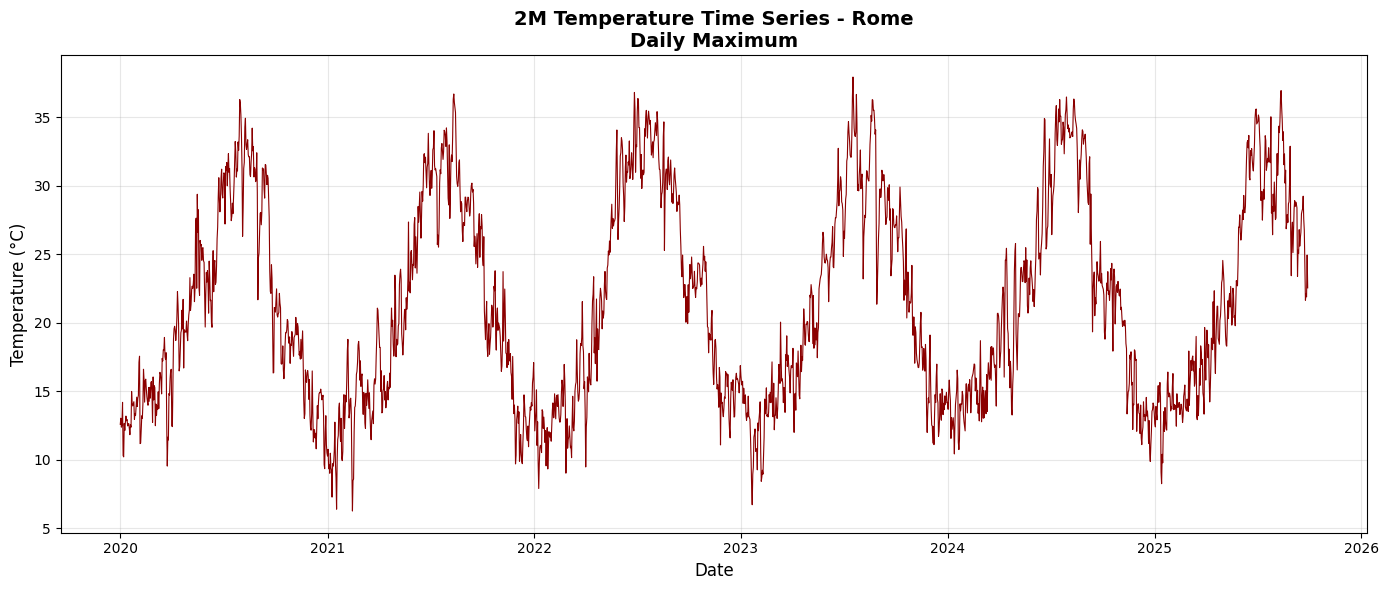

In [34]:
# Plot time series for Rome
fig, ax = plt.subplots(figsize=(14, 6))

# Convert Kelvin to Celsius if temperature
if voi == "2m_temperature":
    (rome_ts - 273.15).plot(ax=ax, linewidth=0.8, color='darkred')
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    rome_ts.plot(ax=ax, linewidth=0.8)
    ax.set_ylabel(f"{voi}", fontsize=12)

ax.set_title(f"{voi.replace('_', ' ').title()} Time Series - Rome\n{statistic.replace('_', ' ').title()}",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Multi-Location Comparative Analysis

Comparison of temperature evolution across four Italian cities demonstrates latitudinal and elevation-driven climate gradients:

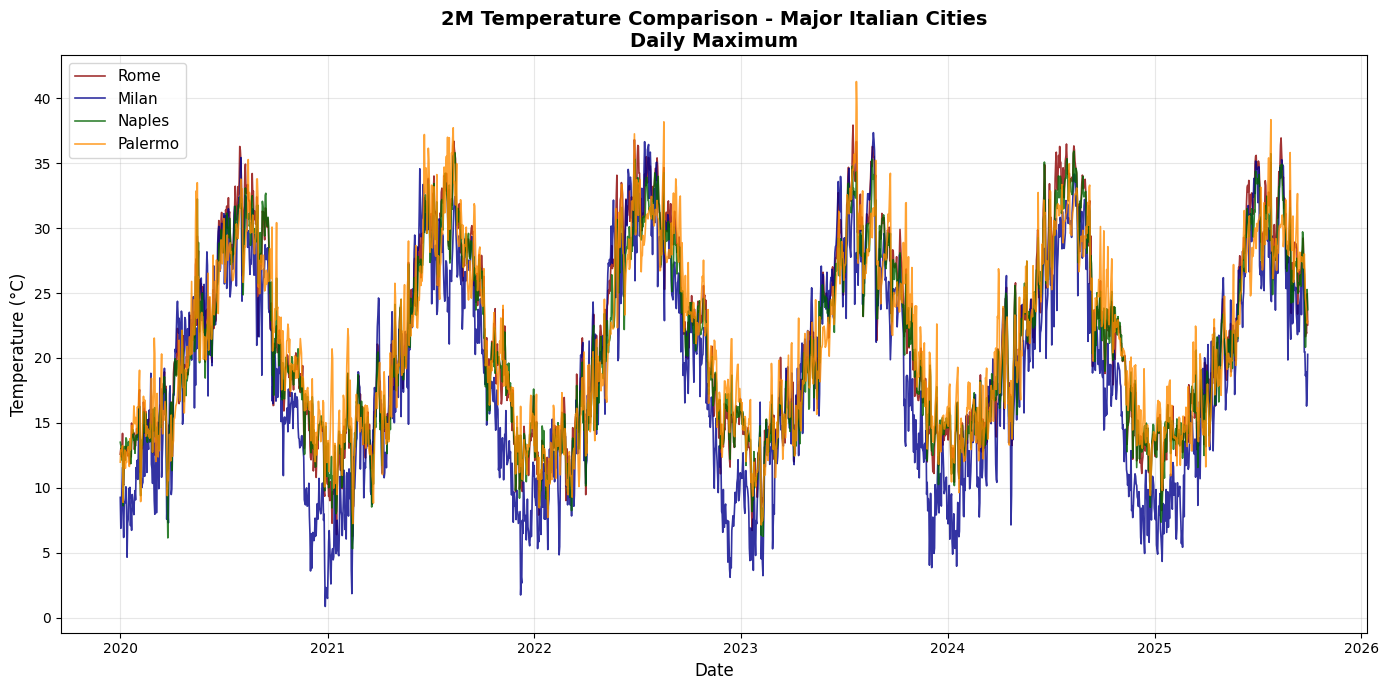

In [35]:
# Extract time series for all cities
city_data = {}
for city_name, coords in cities.items():
    city_ts = era5_var_italy.sel(
        latitude=coords["lat"],
        longitude=coords["lon"],
        method="nearest"
    )
    city_data[city_name] = city_ts

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 7))

colors = ['darkred', 'darkblue', 'darkgreen', 'darkorange']
for (city_name, ts), color in zip(city_data.items(), colors):
    if voi == "2m_temperature":
        (ts - 273.15).plot(ax=ax, label=city_name, linewidth=1.2, alpha=0.8, color=color)
    else:
        ts.plot(ax=ax, label=city_name, linewidth=1.2, alpha=0.8, color=color)

ax.set_title(f"{voi.replace('_', ' ').title()} Comparison - Major Italian Cities\n{statistic.replace('_', ' ').title()}",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
if voi == "2m_temperature":
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    ax.set_ylabel(f"{voi}", fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Statistical Characterization

Spatially-averaged statistics computed across the Italian domain:

In [28]:
# Calculate spatial mean over all of Italy for each time step
italy_mean = era5_var_italy.mean(dim=['latitude', 'longitude'])

# Calculate temporal statistics
temporal_stats = {
    "Overall Mean": italy_mean.mean().values,
    "Overall Std Dev": italy_mean.std().values,
    "Overall Min": italy_mean.min().values,
    "Overall Max": italy_mean.max().values
}

print("📈 Statistical Summary for Italy (spatially averaged):")
print("="*60)
for stat_name, stat_value in temporal_stats.items():
    if voi == "2m_temperature":
        print(f"{stat_name:20s}: {stat_value:.2f} K ({stat_value-273.15:.2f} °C)")
    else:
        print(f"{stat_name:20s}: {stat_value:.4f}")

📈 Statistical Summary for Italy (spatially averaged):
Overall Mean        : 289.89 K (16.74 °C)
Overall Std Dev     : 7.66 K (-265.49 °C)
Overall Min         : 273.48 K (0.33 °C)
Overall Max         : 305.04 K (31.89 °C)


### Temporal Aggregation: Monthly Means

Resampled daily data to monthly resolution using temporal averaging to identify longer-term patterns:

/home/eyad/Progetti/GenHack/.venv/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


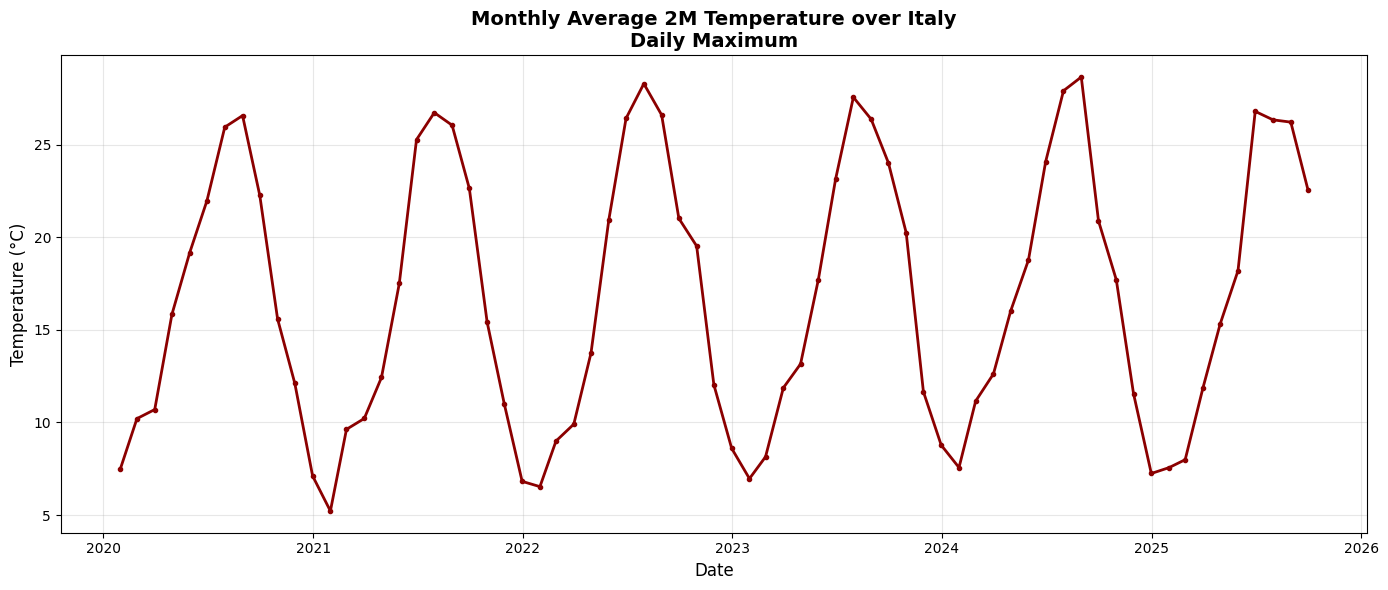

In [29]:
# Resample to monthly means
italy_monthly = italy_mean.resample(valid_time='1M').mean()

# Plot monthly average time series
fig, ax = plt.subplots(figsize=(14, 6))

if voi == "2m_temperature":
    (italy_monthly - 273.15).plot(ax=ax, linewidth=2, marker='o', markersize=3, color='darkred')
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    italy_monthly.plot(ax=ax, linewidth=2, marker='o', markersize=3)
    ax.set_ylabel(f"{voi}", fontsize=12)

ax.set_title(f"Monthly Average {voi.replace('_', ' ').title()} over Italy\n{statistic.replace('_', ' ').title()}",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Climatological Annual Cycle

Monthly climatology computed by averaging all observations for each calendar month across the 5-year period:

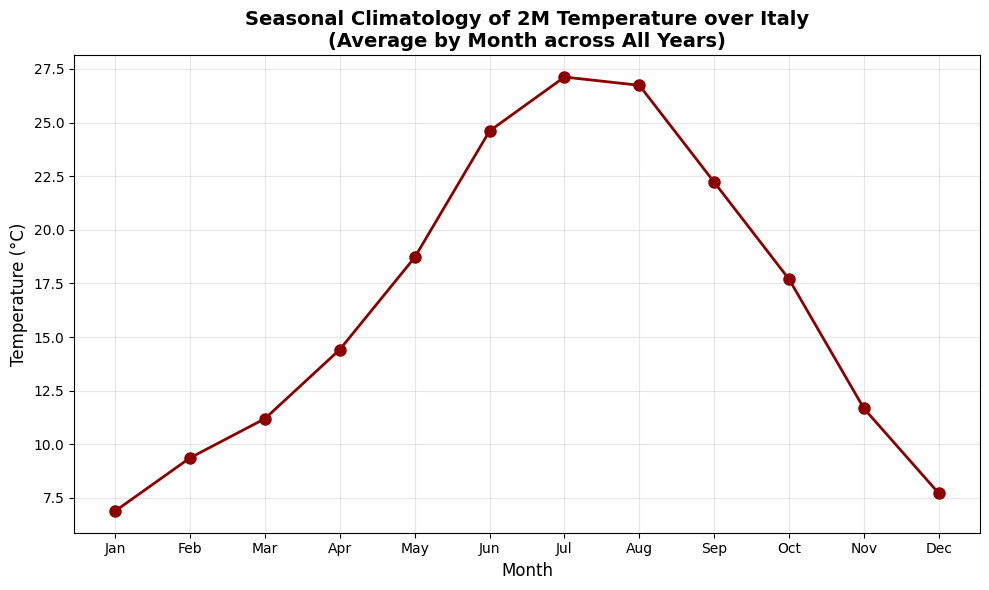

In [30]:
# Group by month and calculate mean
italy_climatology = italy_mean.groupby('valid_time.month').mean()

# Plot seasonal cycle
fig, ax = plt.subplots(figsize=(10, 6))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

if voi == "2m_temperature":
    (italy_climatology - 273.15).plot(ax=ax, marker='o', markersize=8, linewidth=2, color='darkred')
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    italy_climatology.plot(ax=ax, marker='o', markersize=8, linewidth=2)
    ax.set_ylabel(f"{voi}", fontsize=12)

ax.set_title(f"Seasonal Climatology of {voi.replace('_', ' ').title()} over Italy\n(Average by Month across All Years)",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Month", fontsize=12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()